In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import boto3
import seaborn as sns
import awswrangler as wr

%matplotlib inline

In [84]:
session = boto3.Session(
    region_name="us-east-1",
    aws_access_key_id="",
    aws_secret_access_key="",
)

In [85]:
data = wr.dynamodb.read_items(
    table_name="escrow-instruction-control",
    key_condition_expression="#PK = :PK and begins_with(#SK, :SK)",
    expression_attribute_names={"#PK": "PK", "#SK": "SK"},
    expression_attribute_values={":PK": "INSTRUCTION-NORMAL", ":SK": "DATE-"},
    columns=["followUp", "type"],
    max_items_evaluated=100,
    boto3_session=session,
)

In [86]:
scheduled = []
normal = []
canceled_scheduled = []
canceled_normal = []

for idx, items in enumerate(data["followUp"]):
    instruction_type = data["type"][idx]

    if instruction_type in ["block", "unblock"]:
        continue

    normalized = pd.json_normalize(items)
    normalized["minutos"] = (
        normalized["fullDate"]
        .apply(lambda x: pd.to_datetime(x, dayfirst=True))
        .diff()
        / pd.Timedelta("60s")
        
    )

    isScheduled = normalized["description"].str.contains("Instrução agendada").any()
    isCanceled = (
        normalized["description"].str.contains("Instrução cancelada").any()
        or normalized["description"].str.contains("Operação cancelada").any()
    )

    for index, row in enumerate(items):
        subject = "" if row["subject"] is None else f" - {row['subject']}"
        row["description"] = row["description"] + subject
        row["minutos"] = normalized["minutos"][index]
        row["type"] = instruction_type

        if "Instrução não foi processada por falta de saldo" in row["description"]:
            row["description"] = "Instrução não foi processada por falta de saldo"

        if "Instrução agendada para processamento" in row["description"]:
            row["description"] = "Instrução agendada para processamento"

        if isCanceled:
            (
                canceled_scheduled.append(row)
                if isScheduled
                else canceled_normal.append(row)
            )
        else:
            scheduled.append(row) if isScheduled else normal.append(row)

In [87]:
df_s = pd.DataFrame(scheduled)
df_n = pd.DataFrame(normal)

In [88]:
scheduled_rescues = df_s[df_s["type"] == "rescue"]
scheduled_applications = df_s[df_s["type"] == "application"]

normal_rescues = df_n[df_n["type"] == "rescue"]
normal_applications = df_n[df_n["type"] == "application"]
normal_transfers = df_n[df_n["type"] == "transfer"]

In [89]:
def transform(data_frame):
    grouped = (
        data_frame[["description", "minutos"]]
        .groupby(by="description", sort=False)
        .mean()
        .reset_index()
    )

    grouped["minutos"] = grouped["minutos"].round()

    return grouped

#### **Instruções agendadas**

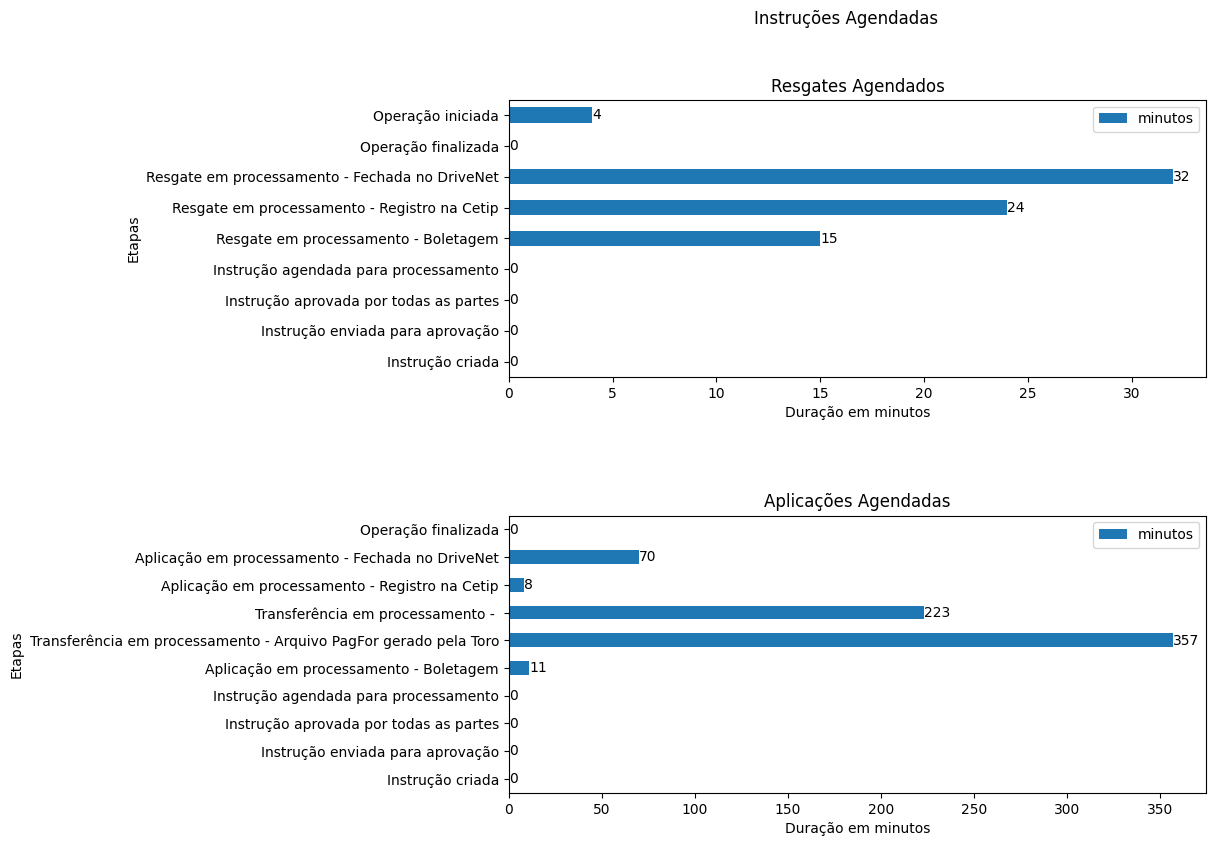

In [90]:
fig, axes = plt.subplots(nrows=2, figsize=(9, 9))
fig.subplots_adjust(hspace=0.5)

fig.suptitle('Instruções Agendadas')

y = "description"
x = "minutos"
x_label = 'Duração em minutos'
y_label = 'Etapas'

df_sr = transform(scheduled_rescues)
df_sa = transform(scheduled_applications)

df_sr.plot(
    ax=axes[0],
    x="description",
    y="minutos",
    kind="barh",
    xlabel=x_label,
    ylabel=y_label,
    title="Resgates Agendados",
)

df_sa.plot(
    ax=axes[1],
    x="description",
    y="minutos",
    kind="barh",
    xlabel=x_label,
    ylabel=y_label,
    title="Aplicações Agendadas",
)

axes[0].bar_label(axes[0].containers[0])
axes[1].bar_label(axes[1].containers[0])

plt.show()

#### **Instruções normais**

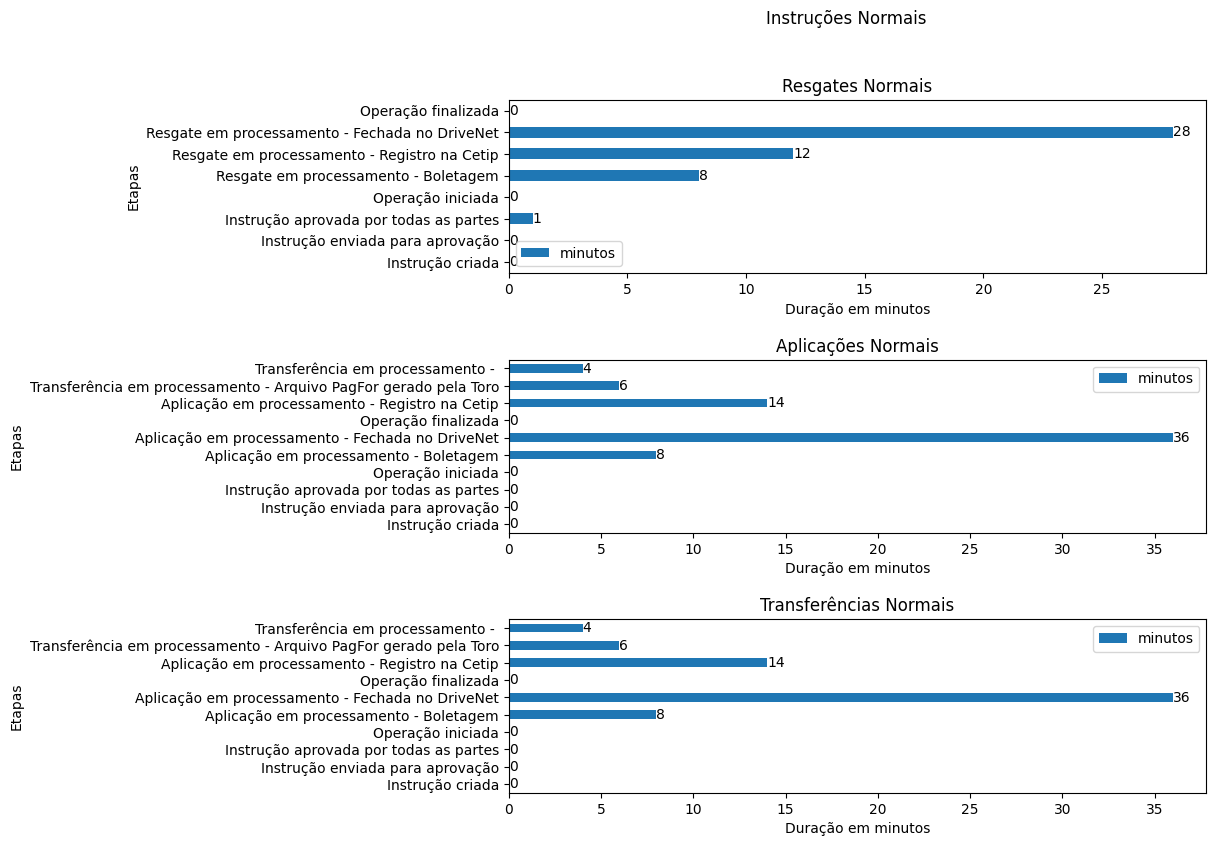

In [91]:
fig, axes = plt.subplots(nrows=3, figsize=(9, 9))
fig.subplots_adjust(hspace=0.5)

fig.suptitle('Instruções Normais')

x = "description"
y = "minutos"
x_label = 'Duração em minutos'
y_label = 'Etapas'

df_nr = transform(normal_rescues)
df_na = transform(normal_applications)
df_nt = transform(normal_transfers)

df_nr.plot(
    ax=axes[0],
    x=x,
    y=y,
    kind="barh",
    xlabel=x_label,
    ylabel=y_label,
    title="Resgates Normais",
)

df_na.plot(
    ax=axes[1],
    x=x,
    y=y,
    kind="barh",
    xlabel=x_label,
    ylabel=y_label,
    title="Aplicações Normais",
)

df_na.plot(
    ax=axes[2],
    x=x,
    y=y,
    kind="barh",
    xlabel=x_label,
    ylabel=y_label,
    title="Transferências Normais",
)

axes[0].bar_label(axes[0].containers[0])
axes[1].bar_label(axes[1].containers[0])
axes[2].bar_label(axes[2].containers[0])

plt.show()